# Example 14: RVT SRA with multiple motions and simulated profiles

Example with multiple input motions and simulated soil profiles.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pysra

%matplotlib inline

In [2]:
# Increased figure sizes
plt.rcParams["figure.dpi"] = 120

## Create a point source theory RVT motion

In [3]:
motions = [
    pysra.motion.SourceTheoryRvtMotion(5.0, 30, "wna"),
    pysra.motion.SourceTheoryRvtMotion(6.0, 30, "wna"),
    pysra.motion.SourceTheoryRvtMotion(7.0, 30, "wna"),
]

for m in motions:
    m.calc_fourier_amps()

## Create site profile

This is about the simplest profile that we can create. Linear-elastic soil and rock.

In [4]:
profile = pysra.site.Profile(
    [
        pysra.site.Layer(
            pysra.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=100),
            10,
            400,
        ),
        pysra.site.Layer(
            pysra.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=200),
            10,
            450,
        ),
        pysra.site.Layer(
            pysra.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=400),
            30,
            600,
        ),
        pysra.site.Layer(pysra.site.SoilType("Rock", 24.0, None, 0.01), 0, 1200),
    ]
)

## Create the site response calculator

In [5]:
calc = pysra.propagation.EquivalentLinearCalculator()

## Initialize the variations

In [6]:
var_thickness = pysra.variation.ToroThicknessVariation()
var_velocity = pysra.variation.DepthDependToroVelVariation.generic_model("USGS C")
var_soiltypes = pysra.variation.SpidVariation(
    -0.5, std_mod_reduc=0.15, std_damping=0.30
)

## Specify the output

In [7]:
freqs = np.logspace(-1, 2, num=500)

outputs = pysra.output.OutputCollection(
    [
        pysra.output.ResponseSpectrumOutput(
            # Frequency
            freqs,
            # Location of the output
            pysra.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pysra.output.ResponseSpectrumRatioOutput(
            # Frequency
            freqs,
            # Location in (denominator),
            pysra.output.OutputLocation("outcrop", index=-1),
            # Location out (numerator)
            pysra.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pysra.output.InitialVelProfile(),        
        pysra.output.MaxAccelProfile()
    ]
)

## Perform the calculation

In [8]:
count = 20
outputs.reset()
for i, p in enumerate(
    pysra.variation.iter_varied_profiles(
        profile,
        count,
        # var_thickness=var_thickness,
        var_velocity=var_velocity,
        # var_soiltypes=var_soiltypes
    )
):
    # Here we auto-descretize the profile for wave propagation purposes
    p = p.auto_discretize()
    for j, m in enumerate(motions):
        name = (f"p{i}", f"m{j}")
        calc(m, p, p.location("outcrop", index=-1))
        outputs(calc, name=name)

## Plot the outputs

Create a few plots of the output.

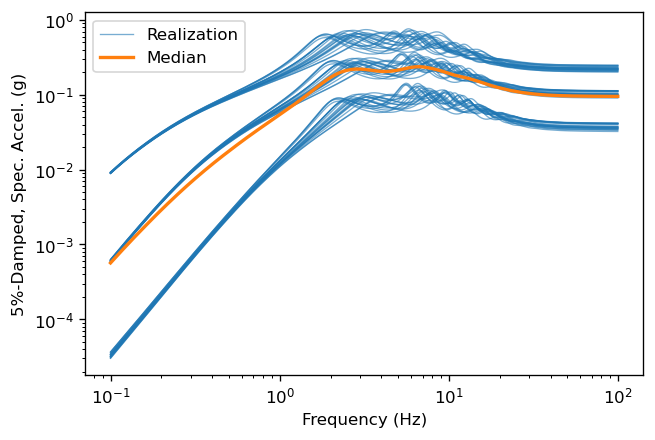

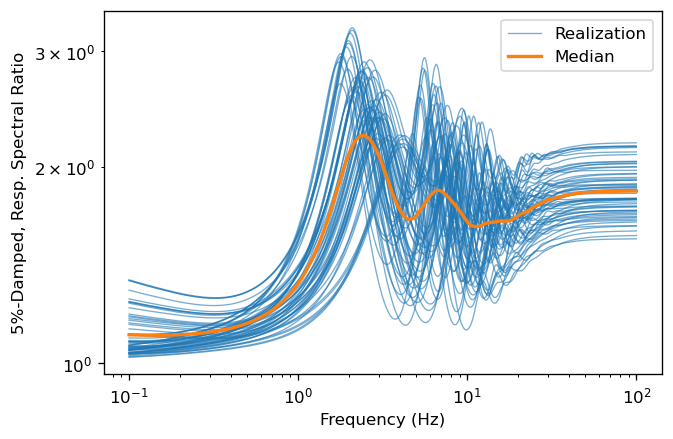

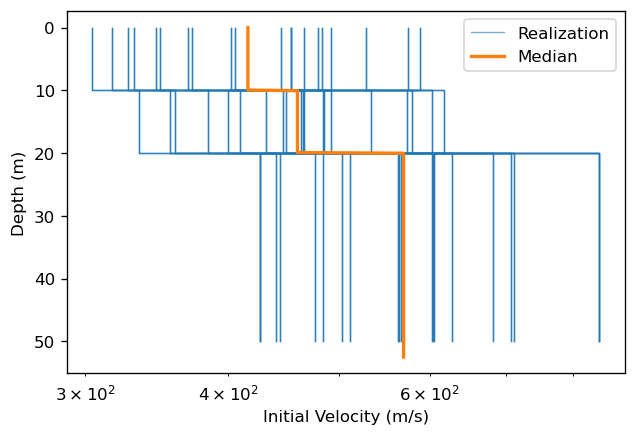

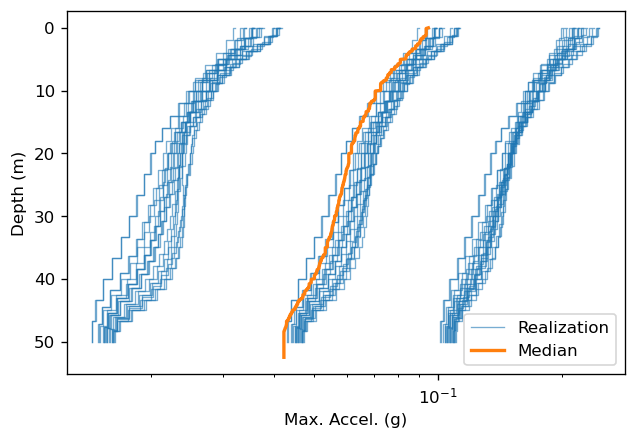

In [9]:
for o in outputs:
    ax = o.plot(style="stats")

## Manipulating output as dataframe

If a `tuple` is passed as the output name, it is used to create a `pandas.MultiIndex` columns.

In [10]:
df = outputs[1].to_dataframe()
df

p0                            p1                      \
                  m0        m1        m2        m0        m1        m2   
0.100000    1.147385  1.049735  1.030413  1.182626  1.061764  1.038342   
0.101394    1.146909  1.049709  1.030656  1.182022  1.061723  1.038643   
0.102807    1.146435  1.049687  1.030901  1.181420  1.061687  1.038946   
0.104240    1.145963  1.049669  1.031149  1.180820  1.061656  1.039253   
0.105693    1.145493  1.049656  1.031400  1.180222  1.061629  1.039563   
...              ...       ...       ...       ...       ...       ...   
94.613238   1.676272  1.623907  1.550252  1.914412  1.833469  1.733761   
95.932095   1.676318  1.623947  1.550303  1.914473  1.833523  1.733832   
97.269336   1.676362  1.623985  1.550352  1.914532  1.833576  1.733901   
98.625218   1.676405  1.624022  1.550399  1.914589  1.833627  1.733968   
100.000000  1.676447  1.624058  1.550445  1.914644  1.833676  1.734033   

                  p2                            p3  ...       p16       p17  \
                  m0        m1        m2        m0  ...        m2        m0   
0.100000    1.129685  1.044019  1.026912  1.189688  ...  1.034445  1.106105   
0.101394    1.129311  1.044002  1.027129  1.189028  ...  1.034717  1.105839   
0.102807    1.128939  1.043989  1.027348  1.188370  ...  1.034992  1.105574   
0.104240    1.128568  1.043980  1.027570  1.187715  ...  1.035270  1.105310   
0.105693    1.128198  1.043974  1.027794  1.187063  ...  1.035551  1.105048   
...              ...       ...       ...       ...  ...       ...       ...   
94.613238   1.781824  1.711629  1.653153  1.738058  ...  1.695223  1.878083   
95.932095   1.781867  1.711660  1.653195  1.738141  ...  1.695285  1.878098   
97.269336   1.781908  1.711691  1.653236  1.738222  ...  1.695345  1.878113   
98.625218   1.781948  1.711720  1.653276  1.738300  ...  1.695403  1.878127   
100.000000  1.781987  1.711749  1.653315  1.738376  ...  1.695459  1.878141   

                                     p18                           p19  \
                  m1        m2        m0        m1        m2        m0   
0.100000    1.035950  1.021849  1.339082  1.106799  1.065400  1.110981   
0.101394    1.035943  1.022028  1.337666  1.106677  1.065886  1.110706   
0.102807    1.035939  1.022209  1.336253  1.106562  1.066378  1.110431   
0.104240    1.035939  1.022392  1.334845  1.106454  1.066876  1.110158   
0.105693    1.035942  1.022577  1.333442  1.106353  1.067379  1.109886   
...              ...       ...       ...       ...       ...       ...   
94.613238   1.787107  1.739853  2.085776  1.947275  1.704084  1.973353   
95.932095   1.787110  1.739868  2.085874  1.947388  1.704216  1.973364   
97.269336   1.787113  1.739881  2.085970  1.947498  1.704344  1.973375   
98.625218   1.787115  1.739894  2.086063  1.947604  1.704467  1.973386   
100.000000  1.787117  1.739907  2.086153  1.947707  1.704587  1.973396   

                                
                  m1        m2  
0.100000    1.037834  1.023185  
0.101394    1.037826  1.023375  
0.102807    1.037822  1.023566  
0.104240    1.037820  1.023760  
0.105693    1.037823  1.023956  
...              ...       ...  
94.613238   1.870479  1.819744  
95.932095   1.870479  1.819758  
97.269336   1.870478  1.819772  
98.625218   1.870478  1.819786  
100.000000  1.870477  1.819799  

[500 rows x 60 columns]

Lets names to the dataframe and transform into a long format. Pandas works better on long formatted tables.

In [11]:
# Add names for clarity
df.columns.names = ("profile", "motion")
df.index.name = "freq"
# Transform into a long format
df = df.reset_index().melt(id_vars="freq")
df

,freq,profile,motion,value
0,0.100000,p0,m0,1.147385
1,0.101394,p0,m0,1.146909
2,0.102807,p0,m0,1.146435
3,0.104240,p0,m0,1.145963
4,0.105693,p0,m0,1.145493
...,...,...,...,...
29995,94.613238,p19,m2,1.819744
29996,95.932095,p19,m2,1.819758
29997,97.269336,p19,m2,1.819772
29998,98.625218,p19,m2,1.819786


In [12]:
def calc_stats(group):
    ln_value = np.log(group["value"])

    median = np.exp(np.mean(ln_value))
    ln_std = np.std(ln_value)

    return pd.Series({"median": median, "ln_std": ln_std})


stats = df.groupby(["freq", "motion"]).apply(calc_stats)
stats

median    ln_std
freq       motion                    
0.100000   m0      1.212031  0.058677
           m1      1.070372  0.020291
           m2      1.043581  0.012893
0.101394   m0      1.211274  0.058425
           m1      1.070314  0.020258
...                     ...       ...
98.625218  m1      1.849403  0.068249
           m2      1.719052  0.060606
100.000000 m0      1.943424  0.078440
           m1      1.849461  0.068254
           m2      1.719127  0.060604

[1500 rows x 2 columns]

In [13]:
stats = (
    stats.reset_index("motion")
    .pivot(columns="motion")
    .swaplevel(0, 1, axis=1)
    .sort_index(axis=1)
)
stats

motion            m0                  m1                  m2          
              ln_std    median    ln_std    median    ln_std    median
freq                                                                  
0.100000    0.058677  1.212031  0.020291  1.070372  0.012893  1.043581
0.101394    0.058425  1.211274  0.020258  1.070314  0.012979  1.043916
0.102807    0.058174  1.210520  0.020227  1.070262  0.013066  1.044254
0.104240    0.057923  1.209769  0.020196  1.070214  0.013154  1.044596
0.105693    0.057672  1.209020  0.020167  1.070173  0.013243  1.044942
...              ...       ...       ...       ...       ...       ...
94.613238   0.078428  1.943176  0.068234  1.849218  0.060609  1.718813
95.932095   0.078431  1.943241  0.068239  1.849281  0.060608  1.718895
97.269336   0.078434  1.943304  0.068244  1.849343  0.060607  1.718975
98.625218   0.078437  1.943365  0.068249  1.849403  0.060606  1.719052
100.000000  0.078440  1.943424  0.068254  1.849461  0.060604  1.719127

[500 rows x 6 columns]

Access the properties of each motion like:

In [14]:
stats["m0"]

,ln_std,median
freq,,
0.100000,0.058677,1.212031
0.101394,0.058425,1.211274
0.102807,0.058174,1.210520
0.104240,0.057923,1.209769
0.105693,0.057672,1.209020
...,...,...
94.613238,0.078428,1.943176
95.932095,0.078431,1.943241
97.269336,0.078434,1.943304


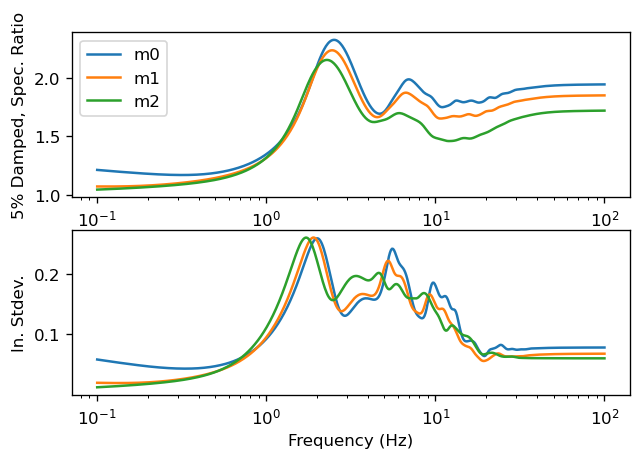

In [15]:
fig, axes = plt.subplots(nrows=2, subplot_kw={"xscale": "log"})

for name, g in stats.groupby(level=0, axis=1):
    for ax, key in zip(axes, ["median", "ln_std"]):
        ax.plot(g.index, g[(name, key)], label=name)


axes[0].set(ylabel="5% Damped, Spec. Ratio")
axes[0].legend()

axes[1].set(ylabel="ln. Stdev.", xlabel="Frequency (Hz)")

fig;